In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dsapol import dsapol
from scipy.signal import correlate
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d
from scipy.signal import peak_widths
from scipy.stats import chi
from scipy.stats import norm
import panel as pn

#from numpy.ma import masked_array as ma
import numpy.ma as ma
from scipy.stats import kstest
from scipy.optimize import curve_fit

#import numpy.ma as ma 
%load_ext autoreload
%autoreload 2 

from scipy.signal import find_peaks
from scipy.signal import peak_widths
import copy
import numpy as np

from sigpyproc import FilReader
from sigpyproc.Filterbank import FilterbankBlock
from sigpyproc.Header import Header
from matplotlib import pyplot as plt
import pylab
import pickle
import json
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.stats import chi
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.ndimage import convolve1d
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
from RMtools_1D.do_QUfit_1D_mnest import run_qufit

plt.rcParams.update({
                    'font.size': 16,
                    'font.family': 'serif',
                    'axes.labelsize': 16,
                    'axes.titlesize': 16,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'xtick.direction': 'in',
                    'ytick.direction': 'in',
                    'xtick.top': True,
                    'ytick.right': True,
                    'lines.linewidth': 1,
                    'lines.markersize': 5,
                    'legend.fontsize': 14,
                    'legend.borderaxespad': 0,
                    'legend.frameon': False,
                    'legend.loc': 'lower right'})


from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u


def gauss_scint(x,bw,amp,off):
    return off + amp*np.exp(-np.log(2)*((x/bw)**2))


def lorentz_scint(x,bw,amp,off):
    return off + amp*(bw/(x**2 + (0.5*bw**2)))

fsize=30
fsize2=20
plt.rcParams.update({
                    'font.size': fsize,
                    'font.family': 'sans-serif',
                    'axes.labelsize': fsize,
                    'axes.titlesize': fsize,
                    'xtick.labelsize': fsize,
                    'ytick.labelsize': fsize,
                    'xtick.direction': 'in',
                    'ytick.direction': 'in',
                    'xtick.top': True,
                    'ytick.right': True,
                    'lines.linewidth': 1,
                    'lines.markersize': 5,
                    'legend.fontsize': fsize2,
                    'legend.borderaxespad': 0,
                    'legend.frameon': False,
                    'legend.loc': 'lower right'})

In [ ]:
# testing w/ actual data
n_t = 1
n_f = 1
ids = "230307aaao"#"220207aabh"#"221029aado"
nickname = "phineas"#"zach"#"mifanshan"
width_native = 4
RA = 177.9
DEC = 71.6
datadir = "/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/"+ids + "_" + nickname + "/"
ibeam = 218
caldate="22-12-18"

(I,Q,U,V,fobj,timeaxis,freq_test_init,wav_test) = dsapol.get_stokes_2D(datadir,ids + "_dev",20480,n_t=n_t,n_f=1,n_off=int(12000//n_t),sub_offpulse_mean=True)
(I_t_init,Q_t_init,U_t_init,V_t_init) = dsapol.get_stokes_vs_time(I,Q,U,V,1,fobj.header.tsamp,n_t,n_off=int(12000//n_t),plot=False,show=True,normalize=True,buff=1,window=30)


Reading stokes param...0Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/230307aaao_phineas/230307aaao_dev_0.fil


# Try again, implementing based on Casey's Template

In [3]:
import matplotlib.ticker as ticker
import param


from matplotlib.widgets import Slider, Button
from matplotlib.widgets import CheckButtons
from matplotlib.widgets import SpanSelector
from matplotlib.widgets import Button
from matplotlib.widgets import TextBox



I2 = copy.deepcopy(I)
Q2 = copy.deepcopy(Q)
U2 = copy.deepcopy(U)
V2 = copy.deepcopy(V)




def pol_plot1(I_t,Q_t,U_t,V_t,I_f,Q_f,U_f,V_f,comp_dict,freq_test,I_t_weights,timestart,timestop,n_t=1,n_f=1,buff_L=1,buff_R=1,n_t_weight=1,sf_window_weights=1,width_native=1,lo=1,comp_width=100,comp_choose_on=False,fixed_comps=[],filt_weights_on=False,comp_num=0,freq_samp_on=False,maxcomps=4):
    fig = plt.figure(figsize=(24,48))
    ax = plt.subplot2grid(shape=(4, 2), loc=(0, 0),colspan=2)
    
    faxs = []
    for i in range(1,maxcomps+1):
        faxs.append(plt.subplot2grid(shape=(4, 2), loc=( (i-1)//2+ 1, (i-1)%2)))
        faxs[i-1].set_xlim(np.min(freq_test[0]),np.max(freq_test[0]))
        faxs[i-1].set_ylabel("S/N")
        if i != maxcomps+1:
            faxs[i-1].set_title("Component #" + str(i))
        else:
            faxs[i-1].set_title("All Components")
            
    faxs.append(plt.subplot2grid(shape=(4, 1), loc=(3, 0),colspan=2))
    faxs[-1].set_xlim(np.min(freq_test[0]),np.max(freq_test[0]))
    faxs[-1].set_ylabel("S/N")
    faxs[-1].set_title("Component #" + str(i))
    faxs[-1].set_xlabel("Frequency (MHz)")
    

    if filt_weights_on:   
        ax.plot((I_t_weights*np.max(I_t)/np.max(I_t_weights))[timestart:timestop],label="weights",linewidth=4,color="purple",alpha=0.75)
        peak = np.argmax(I_t_weights[timestart:timestop])
        ax.set_xlim(int(peak - (1e-3)/(32.7e-6)),int(peak + (1e-3)/(32.7e-6)))
        #ax1.set_xlim(int(peak - (1e-3)/(32.7e-6)),int(peak + (1e-3)/(32.7e-6)))
    else:
        ax.set_xlim(0,timestop-timestart)
        #ax1.set_xlim(0,timestop-timestart)
    
    
    ax.plot(I_t[timestart:timestop],label="I")
    ax.plot(Q_t[timestart:timestop],label="Q")
    ax.plot(U_t[timestart:timestop],label="U")
    ax.plot(V_t[timestart:timestop],label="V")
    ax.legend(loc="upper right")
    if comp_choose_on:
        ax.axvline(lo,color='red')
        ax.axvline(lo+comp_width/n_t,color='red')
        ax.axvspan(lo, lo+comp_width/n_t, alpha=0.5, color='red')
        
        for i in range(len(fixed_comps)):
            ax.axvline(fixed_comps[i][0],color="green")
            ax.axvline(fixed_comps[i][1],color="green")
            ax.axvspan(fixed_comps[i][0], fixed_comps[i][1], alpha=0.5, color='green')
            
            
        
    ax.set_xlabel("Time Sample ({a} $\mu s$)".format(a=np.around(n_t*32.7,1)))
    ax.set_ylabel("S/N")
    #plt.show()
                    
    if freq_samp_on:
        faxs[-1].plot(freq_test[0],I_f,label="I")
        faxs[-1].plot(freq_test[0],Q_f,label="Q")
        faxs[-1].plot(freq_test[0],U_f,label="U")
        faxs[-1].plot(freq_test[0],V_f,label="V")
        
        for i in range(max([len(comp_dict.keys()),5])):
            faxs[i].plot(freq_test[0],comp_dict[i]["I_f"],label="I")
            faxs[i].plot(freq_test[0],comp_dict[i]["Q_f"],label="I")
            faxs[i].plot(freq_test[0],comp_dict[i]["U_f"],label="I")
            faxs[i].plot(freq_test[0],comp_dict[i]["V_f"],label="I")
            
    #fig.tight_layout()  
    
    return fig
    
    

    
class pol_panel1(param.Parameterized):
    
    n_t = param.Integer(default=1,bounds=(1,128),label=r'n_t')
    n_t_prev = 1
    buff_L = param.Integer(default=1,bounds=(0,20),label=r'left buffer')
    buff_R = param.Integer(default=1,bounds=(0,20),label=r'right buffer')
    n_t_weight = param.Integer(default=1,bounds=(1,10),label=r'n_tw')
    sf_window_weights = param.Integer(default=1,bounds=(1,19),step=2,label=r'sf window')
    ibox = param.Integer(default=1,bounds=(1,128),label=r'ibox')
    comp_width = param.Integer(default=10,bounds=(1,128),label=r'mask width')
    log_n_f = param.Integer(default=0,bounds=(0,10),label=r'log2(n_f)')
    n_f = 1
    n_f_prev = 1
    error = param.String(default="")
    
    
    STEP = 0
    
    #dyn_spec = copy.deepcopy(I2)
    I_t = np.nan*np.ones(I2.shape[1])
    Q_t = np.nan*np.ones(I2.shape[1])
    U_t = np.nan*np.ones(I2.shape[1])
    V_t = np.nan*np.ones(I2.shape[1])
    
    I_f_init = I2.mean(1)#np.zeros(I.shape[0])
    Q_f_init = Q2.mean(1)#np.zeros(Q.shape[0])
    U_f_init = U2.mean(1)#np.zeros(U.shape[0])
    V_f_init = V2.mean(1)#np.zeros(V.shape[0])
    
    #***COMPONENT SELECTION MODULE***#
    peak = int(15280)
    timestart = int(peak - (5e-3)/(32.7e-6))
    timestop = int(peak + (5e-3)/(32.7e-6))
    lo_frac = param.Number(default=0,bounds=(0,1),label=r'lower bound',step=1/(timestop-timestart))#param.Number(default=0,bounds=(0,timestop-timestart),label=r'lower bound')
    lo = 0#lo_frac*(timestop-timestart)
    
    #lo = ((timestop-timestart)/2)
    comp_choose_on = False
    filt_weights_on = False
    freq_samp_on = False
    
    fixed_comps = []
    complist_min = []
    complist_max = []
    def clicked_next(self):
        try:
            if self.comp_choose_on:
                self.complist_min.append(int(np.floor(self.lo)))
                self.complist_max.append(int(np.ceil(self.lo+self.comp_width)))
                self.fixed_comps.append([int(np.floor(self.lo)),int(np.ceil(self.lo+self.comp_width))])
                self.param.trigger('next_comp')
            elif self.filt_weights_on and ( self.curr_comp < len(self.fixed_comps)-1):
                #save filter weights for current component
                self.comp_dict[self.curr_comp] =dict()
                self.comp_dict[self.curr_comp]["comp_num"] = self.curr_comp
                self.comp_dict[self.curr_comp]["buff"] = [self.buff_L,self.buff_R]
                self.comp_dict[self.curr_comp]["n_t_weight"] = self.n_t_weight
                self.comp_dict[self.curr_comp]["sf_window_weights"] = self.sf_window_weights
                self.comp_dict[self.curr_comp]["ibox"] = self.ibox
                self.comp_dict[self.curr_comp]["mask_start"] = self.complist_min[self.curr_comp]
                self.comp_dict[self.curr_comp]["mask_stop"] = self.complist_max[self.curr_comp]
                self.comp_dict[self.curr_comp]["weights"] = self.curr_weights
                
                #get spectrum for current component
                """
                I2masked = copy.deepcopy(I2)
                Q2masked = copy.deepcopy(Q2)
                U2masked = copy.deepcopy(U2)
                V2masked = copy.deepcopy(V2)
                for i in range(len(self.fixed_comps)):
                    if i != self.curr_comp:
                        mask = np.zeros(I2.shape)
                        TSTART = int(int(15280/self.n_t) - (5e-3)/(self.n_t*32.7e-6)) + int(self.complist_min[i])
                        TSTOP = int(int(15280/self.n_t) - (5e-3)/(self.n_t*32.7e-6)) + int(self.complist_max[i])
                        mask[:,int(TSTART):int(TSTOP)] = 1
                        I2masked = ma.masked_array(I2,mask)
                        Q2masked = ma.masked_array(Q2,mask)
                        U2masked = ma.masked_array(U2,mask)
                        V2masked = ma.masked_array(V2,mask)
                """
                (I_fmasked,Q_fmasked,U_fmasked,V_fmasked) = dsapol.get_stokes_vs_freq(I2,Q2,U2,V2,1,fobj.header.tsamp,1,self.n_t,freq_test_init,n_off=int(12000/self.n_t),plot=False,show=False,normalize=True,weighted=True,timeaxis=timeaxis,fobj=fobj,input_weights=self.curr_weights)

                
                self.comp_dict[self.curr_comp]["I_f"] = I_fmasked
                self.comp_dict[self.curr_comp]["Q_f"] = Q_fmasked
                self.comp_dict[self.curr_comp]["U_f"] = U_fmasked
                self.comp_dict[self.curr_comp]["V_f"] = V_fmasked
                self.curr_comp += 1
                self.param.trigger('next_comp')
        except Exception as e:
            self.error = "From clicked_next(): " + str(e)
        return
    def clicked_get(self):
        try:
            self.comp_choose_on = not self.comp_choose_on
            self.param.trigger('get_comp')
        except Exception as e:
            self.error = "From clicked_get(): " + str(e)
        return
    def clicked_done(self):
        try:
            if self.comp_choose_on:
                self.comp_choose_on = False
                self.filt_weights_on = True
                self.param.trigger('done')
            elif self.filt_weights_on:
                if ( self.curr_comp < len(self.fixed_comps)-1):
                    print("Still have " + str(len(self.fixed_comps) - self.curr_comp) + " components left")
                else:
                    #save filter weights for current component
                    self.comp_dict[self.curr_comp] =dict()
                    self.comp_dict[self.curr_comp]["comp_num"] = self.curr_comp
                    self.comp_dict[self.curr_comp]["buff"] = [self.buff_L,self.buff_R]
                    self.comp_dict[self.curr_comp]["n_t_weight"] = self.n_t_weight
                    self.comp_dict[self.curr_comp]["sf_window_weights"] = self.sf_window_weights
                    self.comp_dict[self.curr_comp]["ibox"] = self.ibox
                    self.comp_dict[self.curr_comp]["mask_start"] = self.complist_min[self.curr_comp]
                    self.comp_dict[self.curr_comp]["mask_stop"] = self.complist_max[self.curr_comp]
                    self.comp_dict[self.curr_comp]["weights"] = self.curr_weights

                    self.curr_comp += 1

                    self.curr_weights = np.zeros(len(self.curr_weights))
                    for i in range(len(self.fixed_comps)):
                        self.curr_weights += self.comp_dict[i]["weights"]
                    self.curr_weights = self.curr_weights/np.sum(self.curr_weights)
                    self.filt_weights_on = False
                    self.freq_samp_on = True

                    I2 = dsapol.avg_time(I,self.n_t)
                    Q2 = dsapol.avg_time(Q,self.n_t)
                    U2 = dsapol.avg_time(U,self.n_t)
                    V2 = dsapol.avg_time(V,self.n_t)
                    (self.I_f_init,self.Q_f_init,self.U_f_init,self.V_f_init) = dsapol.get_stokes_vs_freq(I2,Q2,U2,V2,1,fobj.header.tsamp,1,self.n_t,freq_test_init,n_off=int(12000/self.n_t),plot=False,show=False,normalize=True,weighted=True,timeaxis=timeaxis,fobj=fobj,input_weights=self.curr_weights)

                    self.STEP = 1
                self.param.trigger('done')

        except Exception as e:
            self.error = "From clicked_done(): " + str(e)
        return
    #up = param.Action(clicked_up)#clicked)
    #down = param.Action(clicked_down)
    next_comp = param.Action(clicked_next,label="Next")
    get_comp = param.Action(clicked_get,label="Get Components")
    done = param.Action(clicked_done,label='Done')
    
    
    #***FILTER WEIGHTS MODULE***#
    comp_dict = dict()
    curr_comp = 0
    curr_weights = []
    
    #click_data = param.Dict(doc="test")
    #print(click_data)
    
    
    #***FREQUENCY DOWNSAMPLE MODULE***#
    I_f = np.nan*np.ones(len(I_f_init))
    Q_f = np.nan*np.ones(len(I_f_init))
    U_f = np.nan*np.ones(len(I_f_init))
    V_f = np.nan*np.ones(len(I_f_init))
    freq_test = copy.deepcopy(freq_test_init)
    
    
    
    
    
    
    #***VIEWING MODULE***#
    def view(self):
        try:
            #self.hi = self.lo + self.comp_width
            #self.lo =(self.lo* (self.n_t_prev/self.n_t))
            #self.hi *= (self.n_t_prev/self.n_t)
            #self.comp_width = self.comp_width*(self.n_t_prev/self.n_t)
            #if self.n_t != self.n_t_prev or self.n_f != self.n_f_prev:
                #self.dyn_spec = dsapol.avg_freq(dsapol.avg_time(I2,self.n_t),self.n_f)


            self.n_t_prev = self.n_t
            self.n_f = 2**self.log_n_f

            #compute timestart, timestop around approx peak
            peak = int(15280/self.n_t)
            timestart = int(peak - (5e-3)/(self.n_t*32.7e-6))
            timestop = int(peak + (5e-3)/(self.n_t*32.7e-6))
            self.lo = self.lo_frac*(timestop-timestart)

            #downsample
            self.I_t = I_t_init[len(I_t_init)%self.n_t:]
            self.I_t = self.I_t.reshape(len(self.I_t)//self.n_t,self.n_t).mean(1)
            self.Q_t = Q_t_init[len(Q_t_init)%self.n_t:]
            self.Q_t = self.Q_t.reshape(len(self.Q_t)//self.n_t,self.n_t).mean(1)
            self.U_t = U_t_init[len(U_t_init)%self.n_t:]
            self.U_t = self.U_t.reshape(len(self.U_t)//self.n_t,self.n_t).mean(1)
            self.V_t = V_t_init[len(V_t_init)%self.n_t:]
            self.V_t = self.V_t.reshape(len(self.V_t)//self.n_t,self.n_t).mean(1)

            #compute weights
            if self.filt_weights_on:
                for i in range(len(self.fixed_comps)):
                    if i != self.curr_comp:
                        mask = np.zeros(len(I_t))
                        TSTART = int(int(15280/self.n_t) - (5e-3)/(self.n_t*32.7e-6)) + int(self.complist_min[i])
                        TSTOP = int(int(15280/self.n_t) - (5e-3)/(self.n_t*32.7e-6)) + int(self.complist_max[i])
                        mask[int(TSTART):int(TSTOP)] = 1
                        self.I_t = ma.masked_array(self.I_t,mask)
                        self.Q_t = ma.masked_array(self.Q_t,mask)
                        self.U_t = ma.masked_array(self.U_t,mask)
                        self.V_t = ma.masked_array(self.V_t,mask)
                self.curr_weights = dsapol.get_weights_1D(self.I_t,self.Q_t,self.U_t,self.V_t,-1,-1,self.ibox,fobj.header.tsamp,self.n_f,self.n_t,freq_test_init,n_off=int(12000/self.n_t),buff=[self.buff_L,self.buff_R],n_t_weight=self.n_t_weight,sf_window_weights=self.sf_window_weights,padded=True,norm=False,timeaxis=timeaxis,fobj=fobj)


            #get frequency spectrum
            if self.freq_samp_on:        
                self.freq_test = (freq_test_init[0])[len(freq_test_init[0])%self.n_f:]
                self.freq_test = self.freq_test.reshape(len(self.freq_test)//self.n_f,self.n_f).mean(1)
                self.freq_test = [self.freq_test]*4


                self.I_f = self.I_f_init[len(self.I_f_init)%self.n_f:]
                self.I_f = self.I_f.reshape(len(self.I_f)//self.n_f,self.n_f).mean(1)
                self.Q_f = self.Q_f_init[len(self.Q_f_init)%self.n_f:]
                self.Q_f = self.Q_f.reshape(len(self.Q_f)//self.n_f,self.n_f).mean(1)
                self.U_f = self.U_f_init[len(self.U_f_init)%n_f:]
                self.U_f = self.U_f.reshape(len(self.U_f)//self.n_f,self.n_f).mean(1)
                self.V_f = self.V_f_init[len(self.V_f_init)%self.n_f:]
                self.V_f = self.V_f.reshape(len(self.V_f)//self.n_f,self.n_f).mean(1)

            return pol_plot1(self.I_t,self.Q_t,self.U_t,self.V_t,self.I_f,self.Q_f,self.U_f,self.V_f,self.comp_dict,self.freq_test,self.curr_weights,timestart,timestop,self.n_t,self.n_f,self.buff_L,self.buff_R,self.n_t_weight,self.sf_window_weights,self.ibox,self.lo,self.comp_width,self.comp_choose_on,self.fixed_comps,self.filt_weights_on,self.curr_comp,self.freq_samp_on)
        except Exception as e:
            self.error = "From view(): " + str(e)
        return
            



In [4]:


def build_pol_tab():
    
    #(I_t_init,Q_t_init,U_t_init,V_t_init) = dsapol.get_stokes_vs_time(I,Q,U,V,1,fobj.header.tsamp,n_t,n_off=int(12000//n_t),plot=True,show=True,normalize=True,buff=1,window=30)

    
    
    pane_test = pn.pane.Markdown('# DSA-110 Polarization Dashboard')
    #pane2_test = pol_panel_all().panel()
    pan1 = pol_panel1()#param.ObjectSelector(default=pans[0], objects=pans)
    #pan2 = pol_panel2()
    
    return pn.Column(pane_test,pan1.view,pan1.param)



In [5]:
pn.extension()
p = pn.param.ParamFunction(build_pol_tab,lazy=True)


In [6]:

d = pn.Column(p)

Column
    [0] ParamFunction(function, lazy=True)
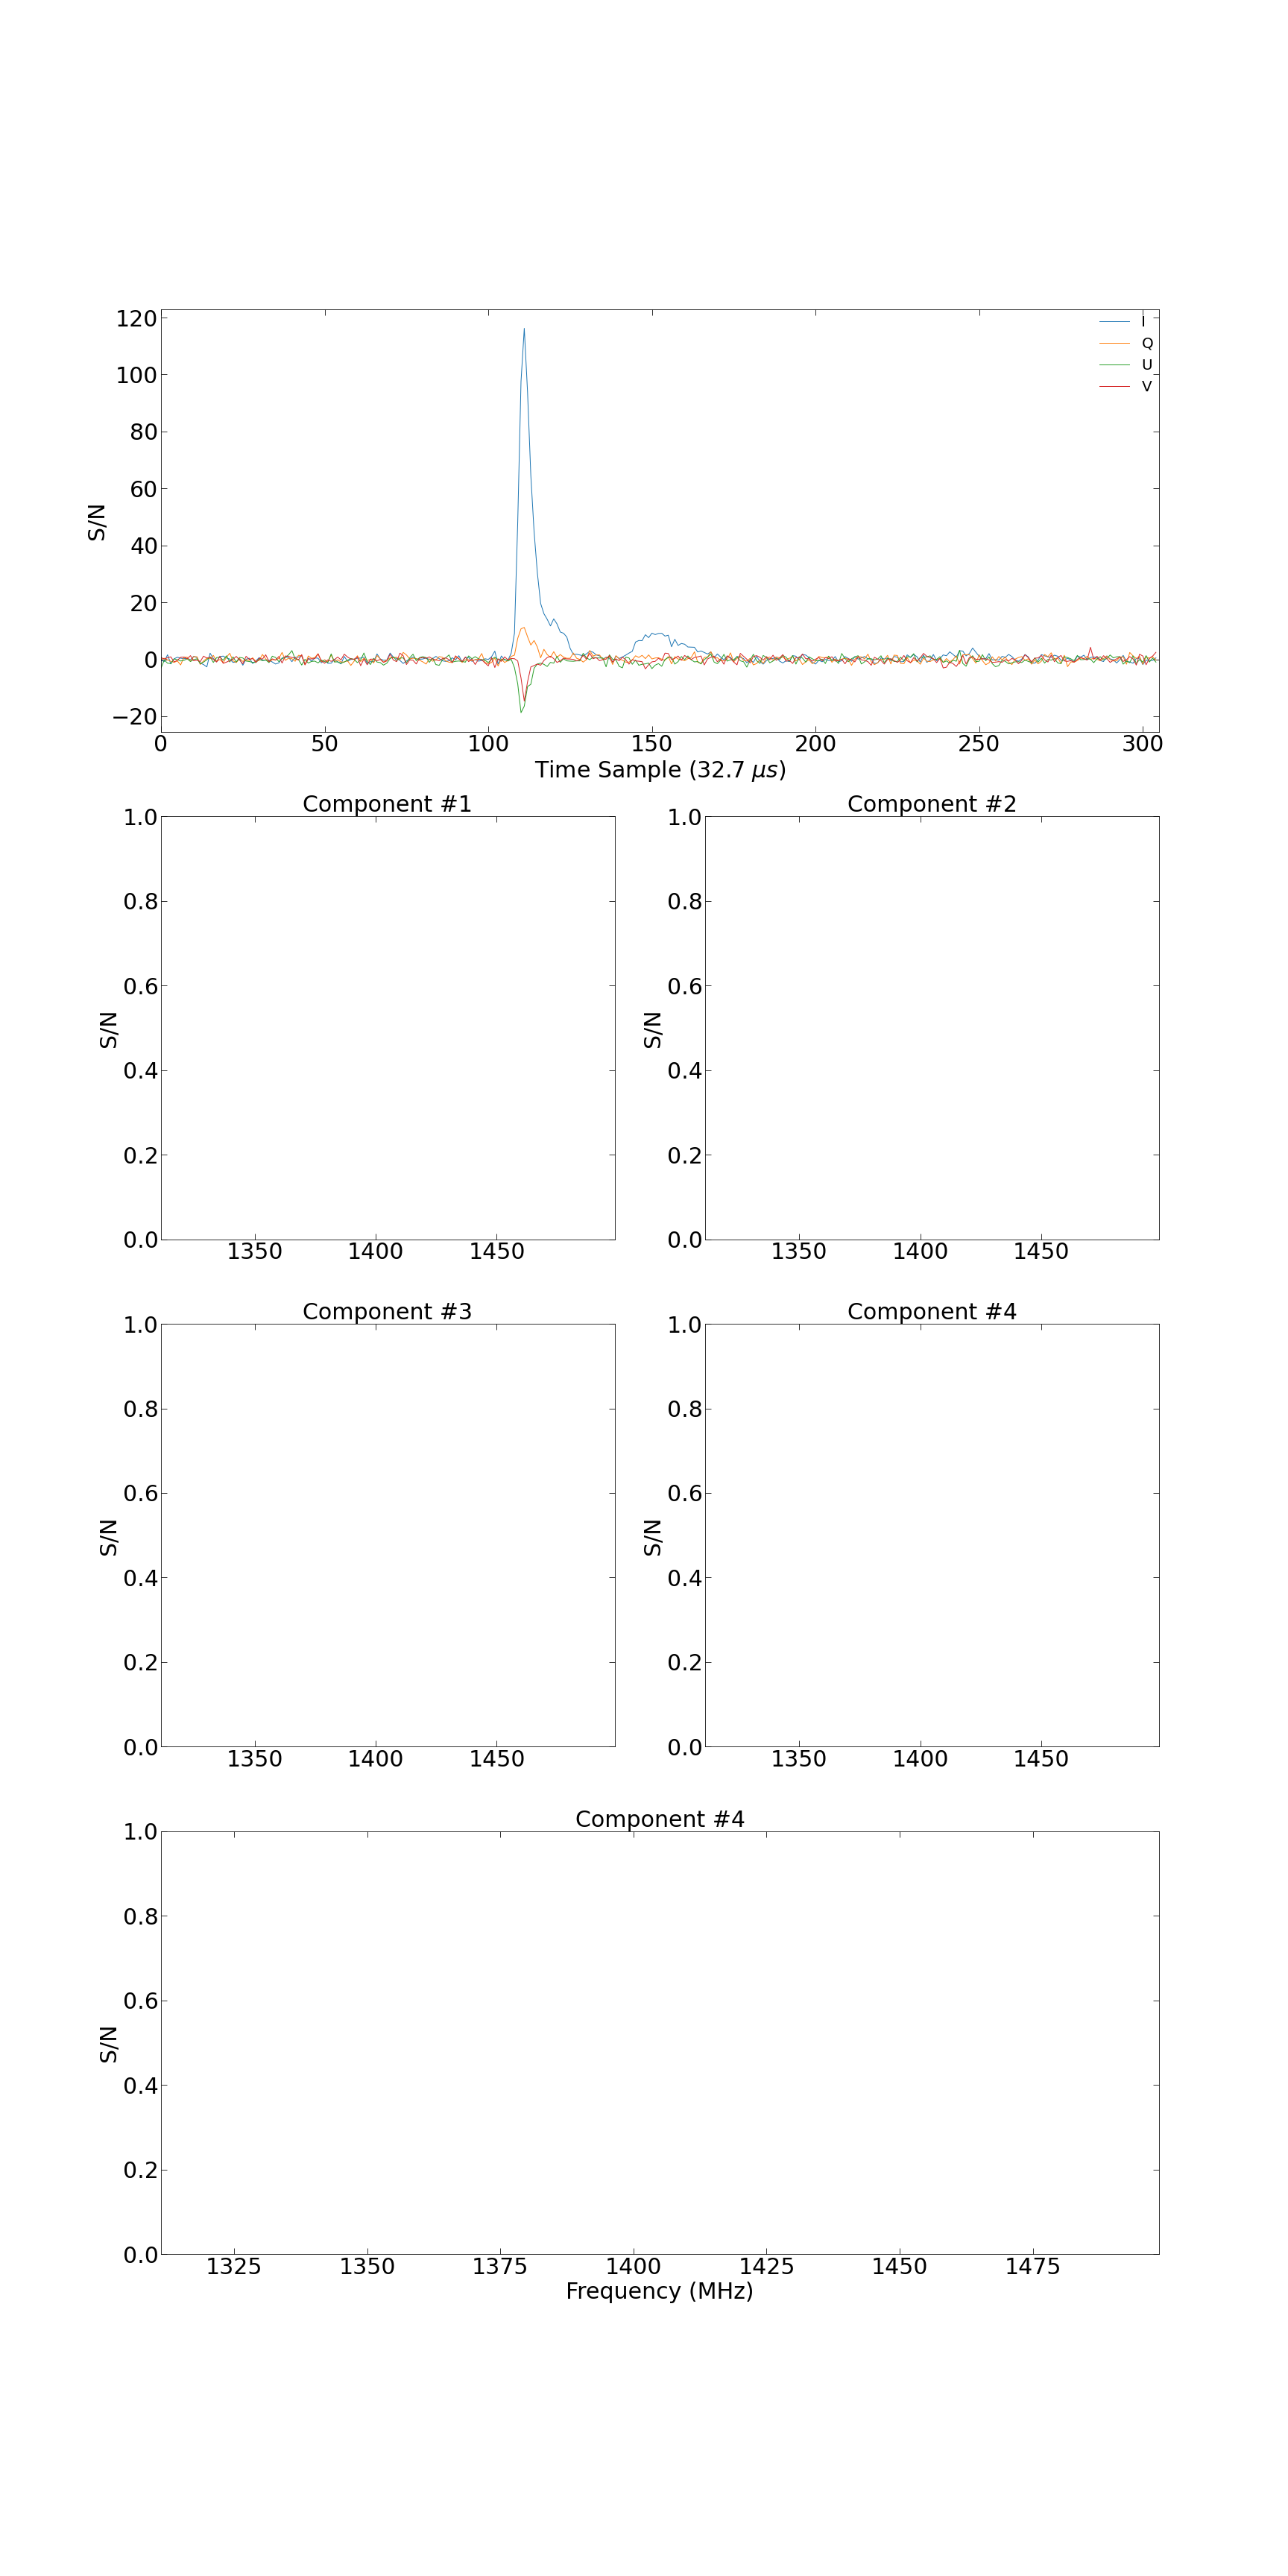

In [8]:
d

Column
    [0] ParamFunction(function, lazy=True)
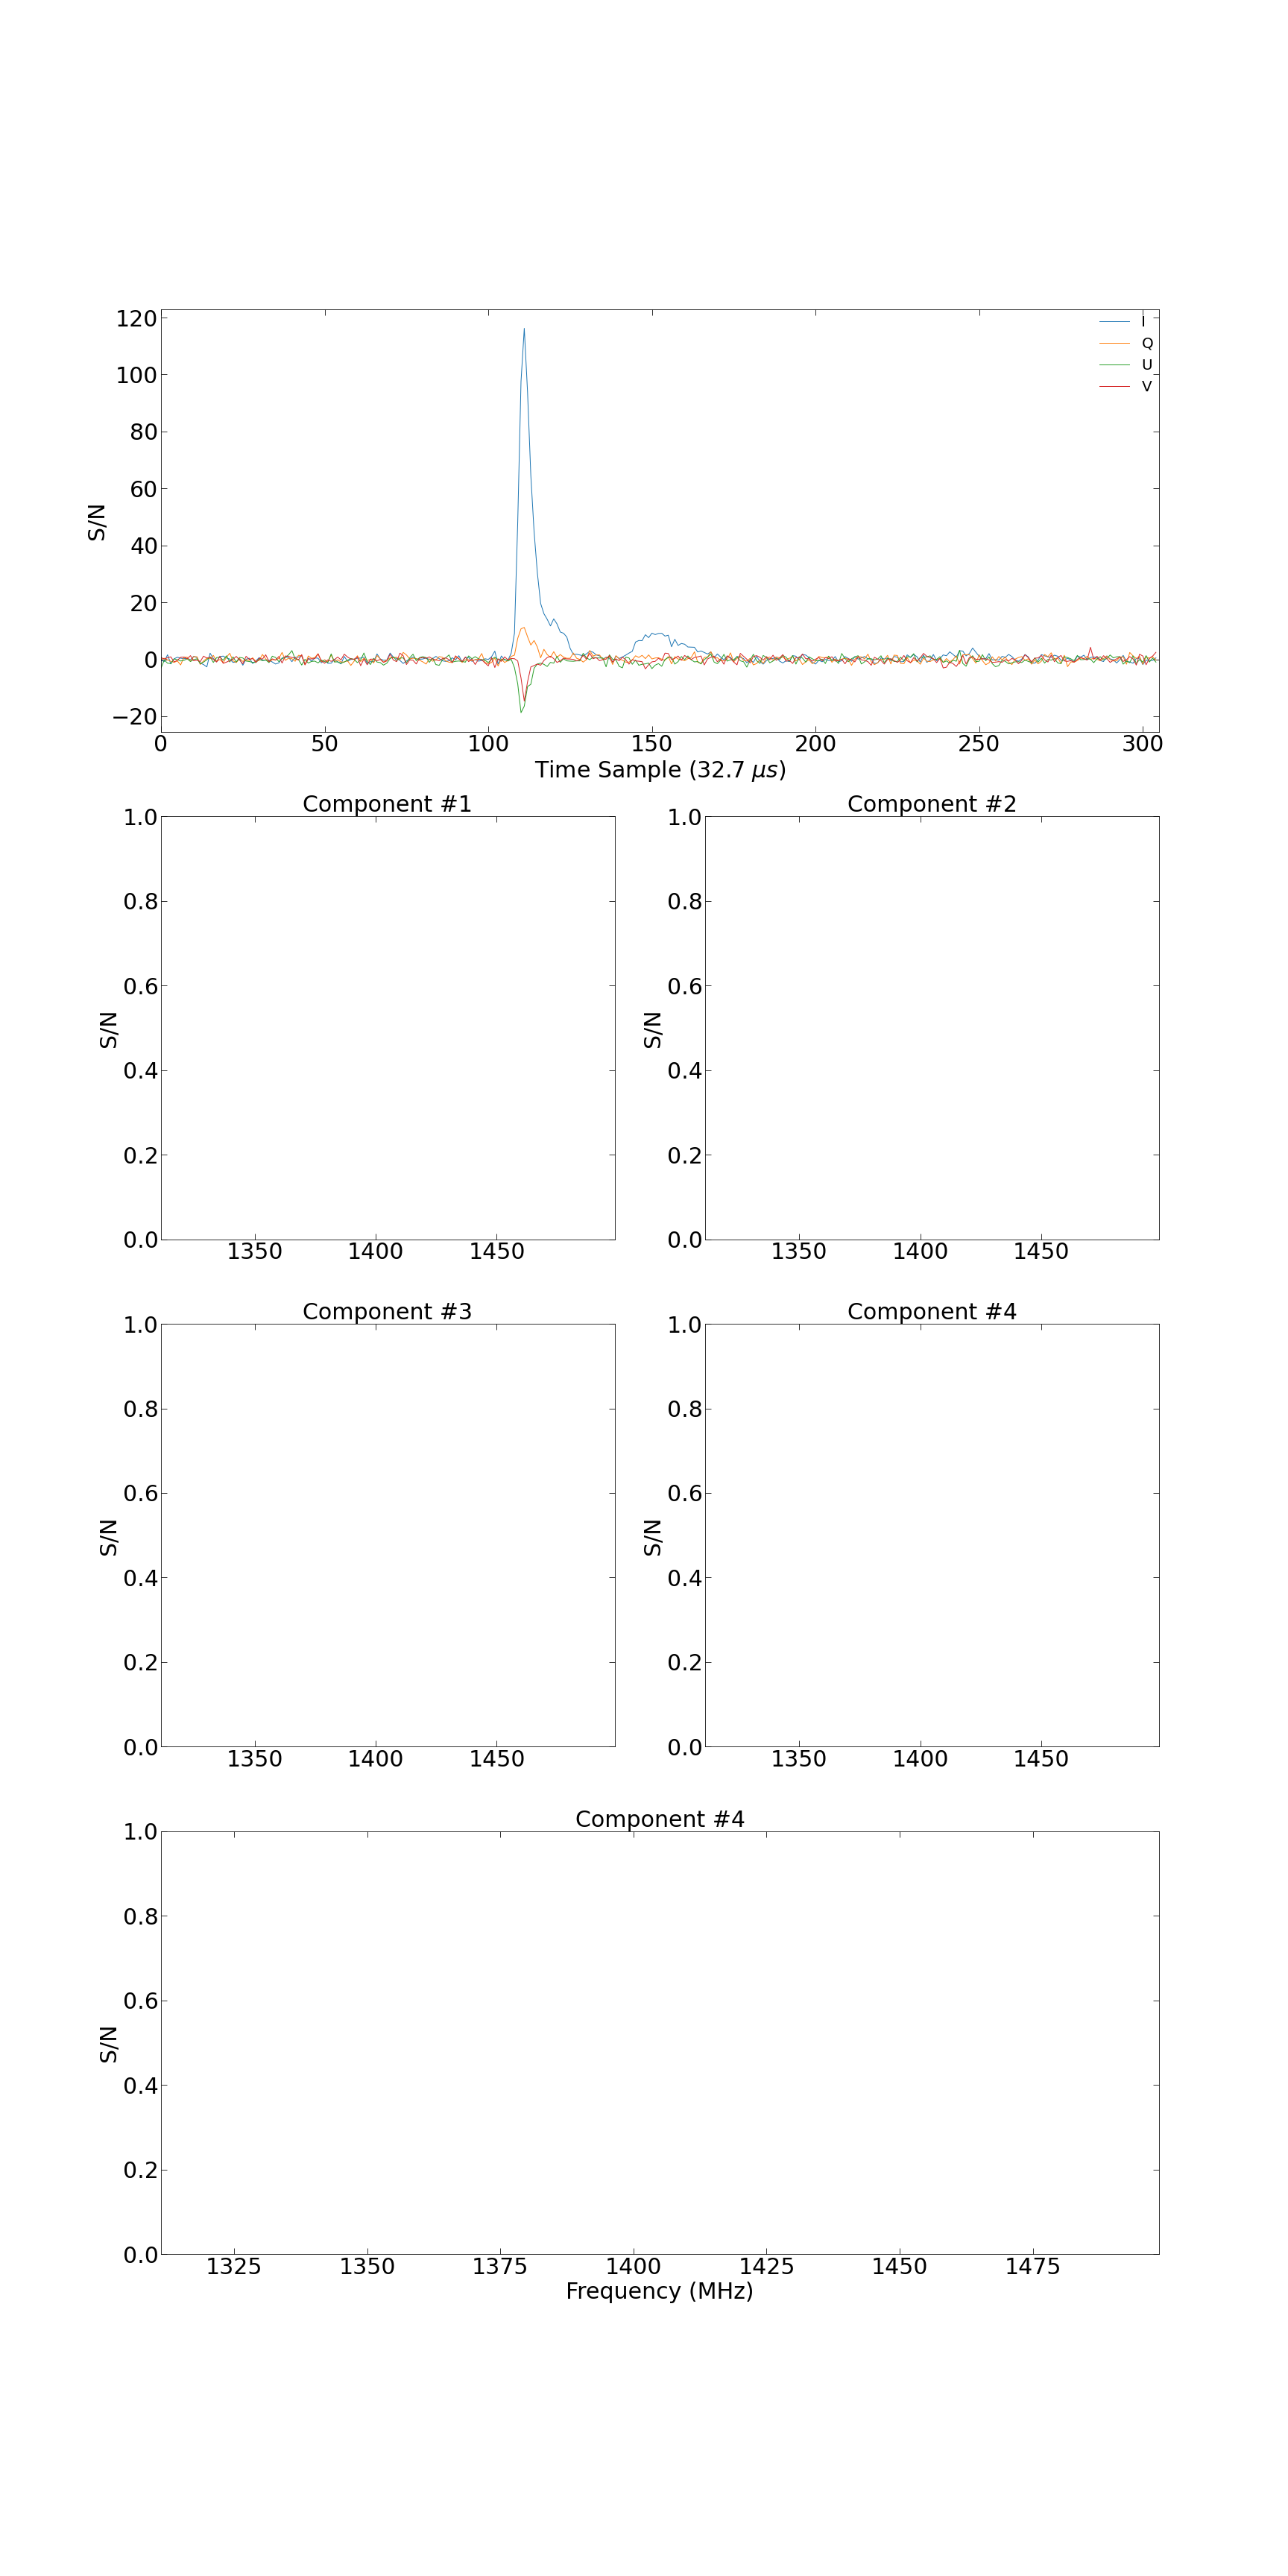

In [9]:
d.servable(title="Polarization")